<a href="https://colab.research.google.com/github/Jaykumar-coder/searce/blob/main/asgn1_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression

import re
import string

import nltk
from nltk.stem import RSLPStemmer
nltk.download('rslp')
from nltk.corpus import stopwords
nltk.download('stopwords')
STOPWORDS = stopwords.words('portuguese')

from scipy.stats import loguniform
from pandas import read_csv
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV

[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Unzipping stemmers/rslp.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Parametrization

In [ ]:
from argparse import Namespace
# Mounting the google drive
from google.colab import drive
drive.mount('/content/drive')
params = Namespace(
    dataset_path = '/content/drive/MyDrive/searce/asgn1/olist_order_reviews_dataset.csv',
    max_features = 300,
    test_size=.30,
    random_state=42,
    max_iter_lg = 10000
)

Mounted at /content/drive


<a id="load-data"></a>
## Load Data

In [ ]:
reviews = pd.read_csv(params.dataset_path)
reviews.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


<a id="select-columns"></a>
## Select Columns

In [ ]:
columns = ['review_comment_message','review_score']
reviews = reviews[columns]
reviews.head()

,review_comment_message,review_score
0,NaN,4
1,NaN,5
2,NaN,5
3,Recebi bem antes do prazo estipulado.,5
4,Parabéns lojas lannister adorei comprar pela I...,5


<a id="remove-null"></a>
## Remove Null Data

In [ ]:
hasNull = reviews.isnull().any().any()

if hasNull :
    print('\nPorcentage (%).')
    print(f'{round((reviews.count()/reviews.isnull().sum()) * 100).replace([np.inf, -np.inf], 0),2}\n')
else:
    print('There are no null data.')


Porcentage (%).
(review_comment_message    72.0
review_score               0.0
dtype: float64, 2)



In [ ]:
print(f'Number of Observations with null data: {reviews.shape[0]}\n')
reviews = reviews.dropna(subset=['review_comment_message'])
print(f'Number of observations after null data removal: {reviews.shape[0]}\n')

Number of Observations with null data: 100000

Number of observations after null data removal: 41753



<a id="label-sentiment"></a>
## Label

In [ ]:
points = [0, 2, 5]
polarities = [0, 1]
reviews['label'] = pd.cut(reviews['review_score'], bins=points, labels=polarities)

reviews = reviews[['review_comment_message','label']]
reviews = reviews.rename(columns={'review_comment_message':'text'})
reviews.head(10)

,text,label
3,Recebi bem antes do prazo estipulado.,1
4,Parabéns lojas lannister adorei comprar pela I...,1
9,aparelho eficiente. no site a marca do aparelh...,1
12,"Mas um pouco ,travando...pelo valor ta Boa.\r\n",1
15,"Vendedor confiável, produto ok e entrega antes...",1
16,"GOSTARIA DE SABER O QUE HOUVE, SEMPRE RECEBI E...",0
19,Péssimo,0
22,Loja nota 10,1
24,obrigado pela atençao amim dispensada,1
27,A compra foi realizada facilmente.\r\nA entreg...,1


<a id="preprocess"></a>
## Pre process

<a id="clear-text"></a>
### Clear Text

In [ ]:
class ClearPipe(BaseEstimator, TransformerMixin):
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        texto_transformado = []
        for texto in X:
            texto = re.sub('\n', ' ', texto)
            
            texto = re.sub('\r', ' ', texto)

            texto = re.sub(r'\d+(?:\.\d*(?:[eE]\d+))?', ' numero ', texto)

            texto = re.sub(r'R\$', ' ', texto)
            texto = re.sub(r'\W', ' ', texto)
            texto = re.sub(r'\s+', ' ', texto)

            urls = re.findall('(http|ftp|https)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', texto)
            if len(urls) == 0:
                pass
            else:
                for url in urls:
                    for link in url:
                        texto = texto.replace(link, '')
                texto = texto.replace(':', '')
                texto = texto.replace('/', '')
          
            texto_transformado.append(texto)
        return texto_transformado

In [ ]:
class StopWordsPipe(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self

    def _removeStopPipe(self, text):
        nopunc = [char for char in text if char not in string.punctuation]
        nopunc = ''.join(nopunc)
        return [word for word in nopunc.split() if word.lower() not in STOPWORDS]

    def transform(self, X, y=None):
        texto_transformado = list(map(lambda c: self._removeStopPipe(c), X))
        texto_transformado = list(map(lambda x: ' '.join(x), texto_transformado))
        return texto_transformado

<a id="Steamming"></a>
### Steamming

In [ ]:
class SteammingPipe(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def _applySteaming(self, c):
        stemmer = RSLPStemmer()
        return list(map(lambda x: stemmer.stem(x), [word for word in c.split()]))
    
    def transform(self, X, y=None):
        texto_transformado = list(map(lambda c: self._applySteaming(c), X))
        texto_transformado = list(map(lambda x: ' '.join(x), texto_transformado))
        return texto_transformado

In [ ]:
pipe_preprocessamento = Pipeline([
    ('clear', ClearPipe()),
    ('stopwords', StopWordsPipe()),
    ('stemming', SteammingPipe()),
])

In [ ]:
text_preprocessed = pipe_preprocessamento.fit_transform(reviews['text'])

<a id="vectorization"></a>
### Vectorization

In [ ]:
vectorizer = CountVectorizer(max_features=params.max_features, stop_words=STOPWORDS)
X = vectorizer.fit_transform(text_preprocessed).toarray()

<a id="split-train"></a>
### Split dataset

In [ ]:
from sklearn.model_selection import train_test_split

y = reviews['label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=params.test_size, random_state=params.random_state)

<a id="modeling"></a>
## Modeling

In [ ]:
model = LogisticRegression( max_iter=params.max_iter_lg,  dual=False)
model.fit(X_train, y_train,)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

<a id="evaluation"></a>
## Evaluation

In [ ]:
acc = cross_val_score(model, X_test, y_test, cv=5, scoring='accuracy')
acc.mean()

0.8684343682945361

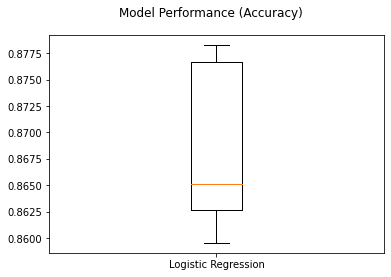

In [ ]:
fig = plt.figure()
fig.suptitle('Model Performance (Accuracy)')
ax = fig.add_subplot(111)
ax.set_xticklabels(['Logistic Regression'])
plt.boxplot(acc)
plt.show()

In [ ]:
def predict(text):
    text_preprocessed = pipe_preprocessamento.fit_transform(text)
    text_transformed = vectorizer.transform(text_preprocessed).toarray()
    pred = model.predict(text_transformed)
    return 'positive' if pred[0] == 1 else 'negative'

In [ ]:
text1 = ['produto de péssima qualidade.']
print(predict(text1))

negative


In [ ]:
text2 = ['Excelente produto, indico']
print(predict(text2))

positive


<a id="hyperparametes-optimization"></a>
## Hyperparametes Optimization

In [ ]:
space = dict()
space['solver'] = ['lbfgs', 'liblinear']
space['penalty'] = ['none', 'l1', 'l2']
space['C'] = loguniform(1e-5, 100)

In [ ]:

cv = RepeatedStratifiedKFold(n_splits=10, random_state=params.random_state)
search = RandomizedSearchCV(model, space, scoring='accuracy', n_jobs=4, cv=cv, random_state=params.random_state)